- different clustering algorithms has different objective

    - closeness of members within group

    - distance between group

    - ratio of above two

    - minimum cut of an NN-graph

# Comparing different clustering algorithms on toy datasets

https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

In [ ]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [ ]:
# ============
# Generate 6 datasets: noisy_circles, noisy_moons, varied, aniso, blobs, no_structure
# ============
np.random.seed(0)

n_samples = 1500

noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# `aniso`: anisotropically (unevenly) distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# `varied`: blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        "Noisy circles", noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 20,
            "xi": 0.25,
        },
    ),
    ("Noisy moons", noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2}),
    (
        "Varied variance", varied, 
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 5,
            "xi": 0.035,
            "min_cluster_size": 0.2,
        },
    ),
    (
        "Unevenly distributed", aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 20,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    ("Blobs", blobs, {}),
    ("No structure", no_structure, {}),
]

/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


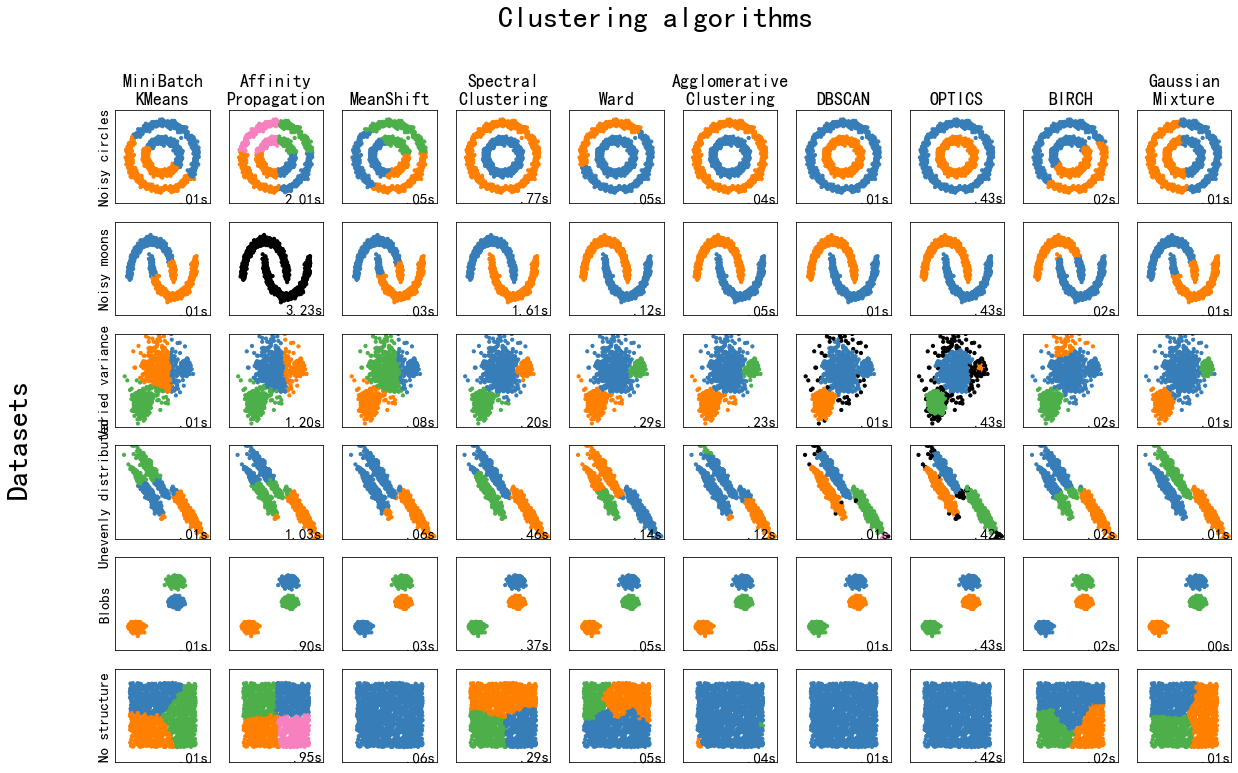

In [29]:
fig, axes = plt.subplots(len(datasets), 10, figsize=(20, 12))

for i, (dataset_name, dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for j, (algo_name, algorithm) in enumerate(clustering_algorithms):
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        # add algorithm name to columns
        if i == 0:
            axes[i][j].set_title(algo_name, size=18)
        # add dataset name to rows
        if j == 0:
            axes[i][j].set_ylabel(dataset_name, size=15)
        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        axes[i][j].scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        axes[i][j].set_xlim(-2.5, 2.5)
        axes[i][j].set_ylim(-2.5, 2.5)
        axes[i][j].set_xticks(())
        axes[i][j].set_yticks(())
        axes[i][j].text(0.99,0.01,("%.2fs" % (t1 - t0)).lstrip("0"),
                        transform=axes[i][j].transAxes, size=15,ha="right")

fig.suptitle("Clustering algorithms", y=1, fontsize=30) 
fig.supylabel("Datasets", x=0.05, fontsize=30) 
plt.show()


# K-means clustering

- K-Means is sensitive to Initialization and Outliers (use K-median)

- loss: within group MSE

## assumption

- K is chosen correctly

- The data is normal distribution

- All clusters have equal variance

- All clusters have the same number of points

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans


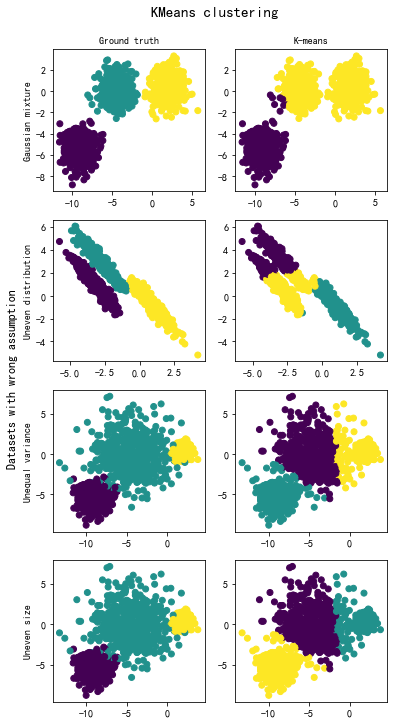

In [71]:
n_samples = 1500
random_state = 170

# "Mixture of Gaussian Blobs"
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Anisotropic blobs
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)  

# Unequal variance
X_varied, y_varied = make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)  

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))  
y_filtered = [0] * 500 + [1] * 100 + [2] * 10


datasets = [( "Gaussian mixture", (X, y), {"n_clusters": 2}),
    ("Uneven distribution", (X_aniso, y),{"n_clusters": 3}),
    ("Unequal variance", (X_varied, y_varied),{"n_clusters": 3}),
    ( "Uneven size", (X_varied, y_varied),{"n_clusters": 3})]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(6, 12))
axs[0, 0].set_title("Ground truth", fontsize=10)
axs[0, 1].set_title("K-means", fontsize=10)


for i, (dataset_name, dataset, params) in enumerate(datasets):
    X, y = dataset 
    y_pred = KMeans(n_clusters=params['n_clusters']).fit_predict(X)
    axs[i, 0].scatter(X[:, 0], X[:, 1], c=y)
    axs[i, 1].scatter(X[:, 0], X[:, 1], c=y_pred)
    axs[i, 0].set_ylabel(dataset_name, fontsize=10)

fig.suptitle(f"KMeans clustering", fontsize=15, y=0.93)
fig.supylabel("Datasets with wrong assumption")
plt.show()


# Spectral clustering

- k-means on eigenvectors of Graph Laplacian $L=U\Lambda U^{-1}$

$$
X \rightarrow U
$$

- adventage of Spectral clustering over k-means clustering:

    - cluster can be arbitrary shape 

    - good for graph data 

## eigenvalues of graph Laplacian

https://towardsdatascience.com/spectral-clustering-aba2640c0d5b

- number of 0 eigenvalues  = number of connected components in graph

- spectral gap: first non-zero smallest eigenvalue. represent density of graph. 

    if a n-node graph is dense, spectral gap = n

- Fiedler value is second-smallest eigenvalue,  
    
    Fiedler value = minimum number of cuts needed to partition graph into 2 connected components

    the entries in Fiedler vector are either positive or negative, belongs to 2 connected components

Text(0.5, 1.0, 'Spectral clustering')

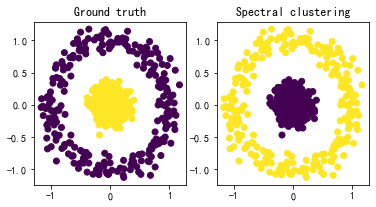

In [132]:
from sklearn import datasets 
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans

X, y = datasets.make_circles(n_samples=500, noise=0.1, factor=.2)
# adjacency matrix
A = kneighbors_graph(X, n_neighbors=5, mode='connectivity').toarray()

# degree matrix
D = np.diag(A.sum(axis=1))

# graph laplacian
L = D-A

# eigenvalues and eigenvectors
vals, vecs = np.linalg.eig(L) 
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]

# use Fiedler value to find best cut to separate data
y_spec = vecs[:,1] > 0

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].scatter(X[:, 0], X[:, 1], c=y)
axs[0].set_title("Ground truth")
axs[1].scatter(X[:, 0], X[:, 1], c=y_spec)
axs[1].set_title("Spectral clustering")